# Analyse de données sous `Python` (classification)

Nous utilisons dans ce TP le module [`scikit-learn`](http://scikit-learn.org/), dédié au *Machine Learning*. Pour mieux la découvrir, nous allons réaliser une étude de cas, avec les données `iris`.

Dans cette étude, nous allons chercher à savoir s'il existe différentes sous-espèces d'iris. Pour cela, nous allons procéder par étapes ::

1. Visualisation des données, via une **ACP**
1. Classification non-supervisée interne à chaque espèce, via **DBSCAN**
1. Analyse des résultats

Dans un premier temps, il va nous falloir importer les données (`iris`) que nous allons utiliser (via la librairie `pydataset`). Nous allons aussi utiliser d'autres librairies (telles que `seaborn`, `numpy`, `matplotlib` et `pandas`).

Nous importerons les éléments de `scikit-learn` (module `sklearn`) au fur et à mesure.

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

%matplotlib inline

Pour rappel, la table se présente comme ceci :

In [2]:
iris = pandas.read_csv("Iris.txt", sep="\t")
iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## ACP

Dans le sous-module `decomposition`, nous allons importer la fonction [`PCA()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Le fonctionnement de celle-ci est similaire à toutes les autres dans `scikit-learn`. 

1. On créé d'abord un objet (nommé ici `pca`) qui va contenir le résultat de l'ACP. Dans la fonction `PCA()`, on pourra indiquer les paramètres tels que le nombre de composants à retenir (`n_components`) ou la méthode de calcul (`svd_solver`).
2. Ensuite, on ajuste (*fit*  en anglais) sur des données avec la fonction `fit()` de l'objet précédemment créé. Dans cette fonction, nous devons donc passer les données à utiliser.

Si l'on souhaite une ACP normée, il nous faut standardiser les données en amont, avec la fonction `scale()` du sous-module `preprocessing` (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives.

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca = PCA()
pca.fit(scale(iris[iris.columns[:4]]))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

L'objet `pca` comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (`explained_variance_`) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (`explained_variance_ratio_`).

In [4]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[2.93808505 0.9201649  0.14774182 0.02085386]
[0.72962445 0.22850762 0.03668922 0.00517871]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les valeurs propres, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [5]:
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(4)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
eig

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,2.938085,73.0,73.0
1,Dim2,0.920165,23.0,96.0
2,Dim3,0.147742,4.0,99.0
3,Dim4,0.020854,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

Text(3.25, 26, '25%')

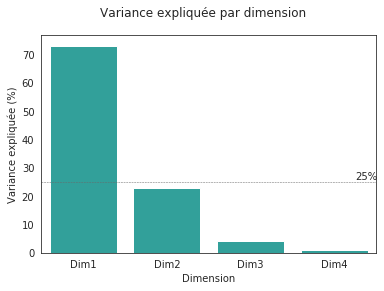

In [6]:
g_eig = seaborn.barplot(x = "Dimension", 
                y = "% variance expliquée",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "Variance expliquée (%)")
g_eig.figure.suptitle("Variance expliquée par dimension")
plt.axhline(y = 25, linewidth = .5, color = "dimgray", linestyle = "--") # 25 = 100 / 4 (nb dimensions)
plt.text(3.25, 26, "25%")

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 96 %  de la variance des données. Nous allons maintenant calculer les coordonnées des iris sur les dimensions, avec la fonction `transform()` de l'objet `pca`.

In [7]:
iris_pca = pca.transform(iris[iris.columns[:4]])

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un `DataFrame` `pandas` en ne prenant que les deux premières dimensions, ainsi que les espèces.

In [8]:
# Transformation en DataFrame pandas
iris_pca_df = pandas.DataFrame({
    "Dim1" : iris_pca[:,0], 
    "Dim2" : iris_pca[:,1], 
    "Species" : iris.Species
})

# Résultat (premières lignes)
iris_pca_df.head()

,Dim1,Dim2,Species
0,2.640270,5.204041,setosa
1,2.670730,4.666910,setosa
2,2.454606,4.773636,setosa
3,2.545517,4.648463,setosa
4,2.561228,5.258629,setosa


Il est maintenant possible de représenter les données sur le premier plan factoriel, en ajoutant bien évidemment l'information sur les espèces.

Text(0.5, 0.98, 'Premier plan factoriel')

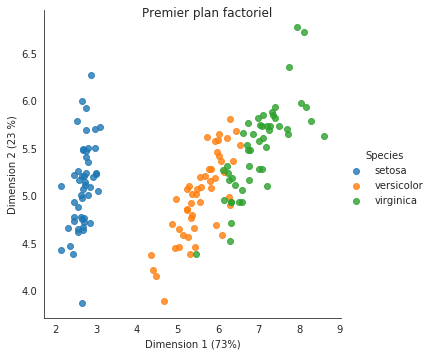

In [9]:
g_pca = seaborn.lmplot("Dim1", "Dim2", hue = "Species", data = iris_pca_df, fit_reg = False)
g_pca.set(xlabel = "Dimension 1 (73%)", ylabel = "Dimension 2 (23 %)")
g_pca.fig.suptitle("Premier plan factoriel")

Il est aussi possible de différencier l'affichage de ce premier plan par espèce, grâce à l'option `col` de `lmplot()`

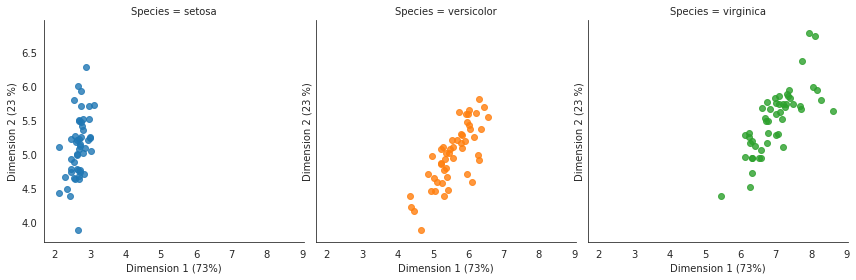

In [15]:
g_pca2 = seaborn.lmplot("Dim1", "Dim2", hue = "Species", col = "Species", data = iris_pca_df, 
                        fit_reg = False, height = 4)
g_pca2.set(xlabel = "Dimension 1 (73%)", ylabel = "Dimension 2 (23 %)")

## DBSCAN

[`DBSCAN`](https://fr.wikipedia.org/wiki/DBSCAN) est un algorithme de classification non supervisée, basé sur la densité. Il est intéressant car il ne nécessite pas de connaître le nombre de classes, mais une estimation de la densité (globale) des données. En effet, les points proches (distance inférieure à $\varepsilon$) sont consiédérés dans la même classe. Si toutefois cette classe comporte au moins un cetain nombre de points au final. Si ce n'est pas le cas, les points sont considérés comme *outliers* et mis à part.

Nous utilisons ici la fonction [`DBSCAN()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) du sous-module `cluster`. Celle-ci peut prendre en paramètre, entre autres, la valeur de $\varepsilon$ (`eps`, `.5` par défaut) et le nombre minimal d'objets dans une classe (`min_samples`, `5` par défaut).

Puis nous ajustons les données standardisées (pour ne pas donner plus d'influences à une variable qu'à une autre).

In [16]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps = .6, min_samples = 3)
db.fit(scale(iris[iris.columns[:4]]))

DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

Les classes dont contenues dans l'objet `labels_` de `db`. On a pour chaque individu sa classe (de $0$ à $K-1$ pour $K$ classes obtenues). Les *outliers* sont étiquettés $-1$ .

In [17]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

On peut faire un tableau récapitulatif des effectifs par classes.

In [18]:
eff = numpy.unique(db.labels_, return_counts = True)
pandas.DataFrame({
    "Classe" : eff[0],
    "Effectif" : eff[1]
})

,Classe,Effectif
0,-1,9
1,0,49
2,1,86
3,2,3
4,3,3


Pour la représentation des données, on ajoute ces labels de classe aux projections des iris sur le premier plan factoriel.

In [19]:
iris_pca_db = iris_pca_df.assign(Labels = db.labels_)

On peut ainsi représenter les données en fonction des espèces et des classes obtenues.

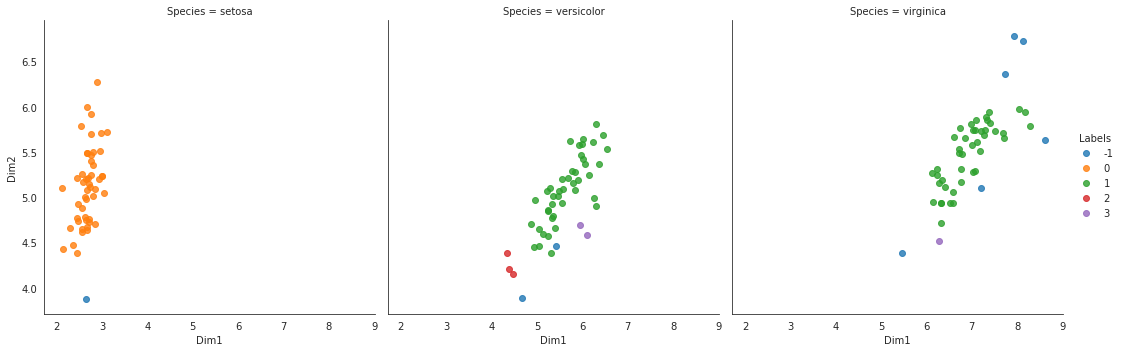

In [20]:
seaborn.lmplot("Dim1", "Dim2", hue = "Labels", col = "Species", data = iris_pca_db, fit_reg = False)

On peut aussi *splitter* le graphique en ligne pour chaque classe.

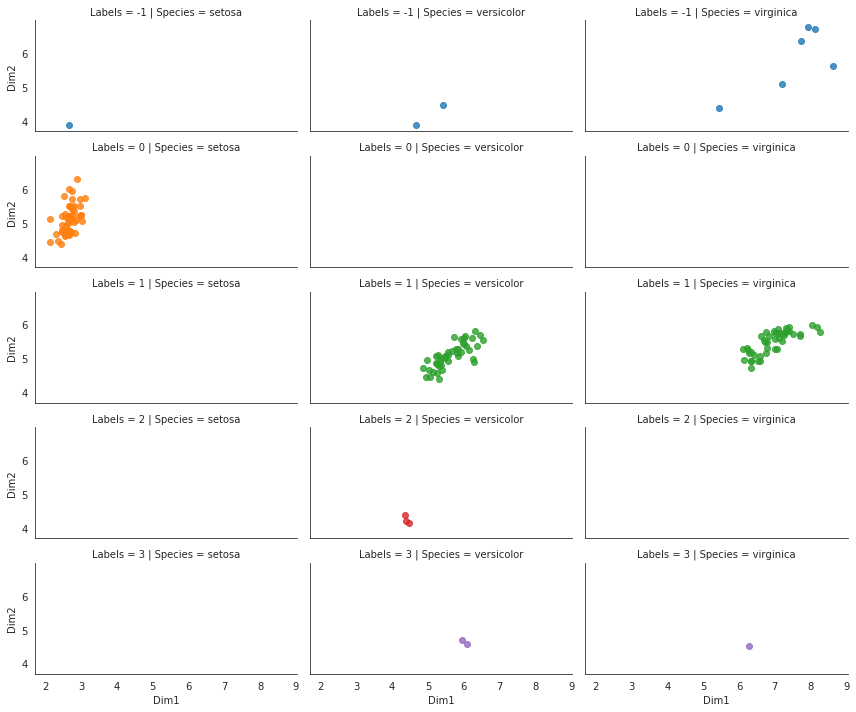

In [23]:
seaborn.lmplot("Dim1", "Dim2", hue = "Labels", col = "Species", row = "Labels", data = iris_pca_db, 
               fit_reg = False, height = 2, aspect = 2)

## Exercice

### ACP

Nous allons travailler ici sur les données de température mondiale HadCRUT4, fournies par [Climate Research Unit](https://crudata.uea.ac.uk/). Vous trouverez plus d’informations sur ces données sur ce [lien](https://crudata.uea.ac.uk/cru/data/temperature/). Nous avons ici l’historique des anomalies moyennes mensuelles et annuelles depuis 1850, au niveau mondial, par rapport à la période 1961-1990.

Le code ci-dessous télécharge directement les dernières données disponibles et les met dans un DataFrame dont vous avez un aperçu en dessous (en supprimant l’année 2019, incomplète).

In [24]:
had = pandas.read_csv("https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat", header=None)
donnees = pandas.DataFrame(
    [list(map(lambda v: float(v), filter(lambda v: v!= "", h.split(" ")))) for h in had[0][::2]],
    columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Annual"]
)
donnees.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
165,2015.0,0.705,0.689,0.708,0.673,0.711,0.743,0.697,0.740,0.796,0.845,0.840,1.024,0.763
166,2016.0,0.934,1.111,1.106,0.937,0.707,0.744,0.744,0.790,0.729,0.598,0.553,0.620,0.797
167,2017.0,0.739,0.845,0.873,0.737,0.659,0.641,0.651,0.714,0.557,0.571,0.554,0.600,0.677
168,2018.0,0.554,0.528,0.615,0.627,0.587,0.573,0.594,0.586,0.598,0.678,0.590,0.638,0.597
169,2019.0,0.738,0.662,0.874,0.780,0.610,0.708,0.706,0.724,0.000,0.000,0.000,0.000,0.724


Vous devez donc réaliser les étapes suivantes :

- Décrire rapidement les données
- Réaliser une ACP centrée ou normée (choix à justifier), sur les données mensuelles
- Ajouter la moyenne annuelle en variable supplémentaire
- Produire les graphiques nécessaires à l’interprétation
- Identifier des années particulières
    - Refaire l’ACP en les indiquant comme individus supplémentaires
    - Comparer les résultats pour voir s’il est opportun ou non de les garder dans l’analyse
- Que peut-on dire globalement ?


### DBSCAN

La banque mondiale fournit un grand nombre de données, dont des indicateurs de gouvernance au niveau mondial (voir [ici](https://data.worldbank.org/data-catalog/worldwide-governance-indicators)). Le code ci-dessous importe les données du fichier [WGI_Data.csv](https://fxjollois.github.io/cours-2017-2018/analyse-donnees/WGI_Data.csv) (que vous devez donc télécharger) pour les importer. Les informations concernant la définition des indicateurs et leur source se trouvent dans le fichier [WGI_Definition and Source.csv](https://fxjollois.github.io/cours-2017-2018/analyse-donnees/WGI_Definition%20and%20Source.csv).

In [25]:
wgi_one = pandas.read_csv("WGI_Data.csv")
wgi_one.head()

,Country Name,Country Code,Series Name,Series Code,Value
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.56373512744904
1,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-1.2221063375473
2,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.74916744232178
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-1.32791936397552
4,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.61642956733704


In [26]:
wgi_bis = wgi_one[["Country Name", "Series Code", "Value"]][wgi_one.Value != ".."]
wgi_ter = wgi_bis.astype({"Value": float})
wgi = wgi_ter.pivot_table(values = "Value", index = "Country Name", columns = "Series Code")
wgi.head()

Series Code,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST
Country Name,,,,,,
Afghanistan,-1.563735,-1.222106,-2.749167,-1.616430,-1.327919,-1.086220
Albania,-0.397567,-0.000573,0.257720,-0.347468,0.188962,0.159191
Algeria,-0.691359,-0.544695,-1.139282,-0.849319,-1.171843,-0.877241
American Samoa,1.230341,0.531472,1.192534,1.328246,0.136647,NaN
Andorra,1.230341,1.860201,1.396047,1.564011,0.871409,1.197540


Vous devez donc réaliser les étapes suivantes :

- Réaliser la classification avec DBSCAN
- Décrire les classes ainsi obtenues pour chaque critère
- Réaliser une ACP pour visualiser les partitions obtenues sur le premier plan factoriel
- Comparer les partitions obtenues en utilisant différentes valeurs du paramètre `eps`